In [33]:
import numpy as np
import pandas as pd
import glob
from zoneinfo import ZoneInfo
from datetime import timezone
from pprint import pprint
import random
import math
import os

In [34]:
APPLE_WATCH_SAMPLE_RATE = 30 # hz

# TimeZone Info
TZ_US_LA = ZoneInfo('America/Los_Angeles')
TZ_UTC = timezone.utc

# TODO: find better way to encode these one-hot vector...

# (
# club type {0=iron/wedges, 1=driver, 2=fairway, 3=hybrid}, -> to one-hot
# shaft stiff ness {0=lite, 1=regular, 2=stiff, 3=x_stiff} -> keep as number as these do have ordinal meaning
# loft_deg, lie_deg, offset_mm, length_inches
# )
CLUB_TYPE_MAPPING = {
    # Irons used were Cobra LTDx Irons set, Right Hand, Standard, Stainless Steel Shalf Regular
    '4 Iron': (*[1,0,0,0], 1, 18.5, 62.00, 5.4, 39.25),
    '5 Iron': (*[1,0,0,0], 1, 20.5, 62.50, 4.6, 38.5),
    '6 Iron': (*[1,0,0,0], 1, 23.5, 63.00, 3.9, 37.75),
    '7 Iron': (*[1,0,0,0], 1, 26.5, 63.50, 3.2, 37.25),
    '8 Iron': (*[1,0,0,0], 1, 31.0, 64.00, 2.6, 36.75),
    '9 Iron': (*[1,0,0,0], 1, 36.0, 64.50, 2.0, 36.25),
    'Pitch Wedge': (*[1,0,0,0], 1, 41.5, 65.00, 1.5, 36.00),
    'Gap Wedge': (*[1,0,0,0], 1, 47.5, 65.00, 1.0, 35.75),
    # Sand Wedge are actually TaylorMade MG3 56.12 
    'Sand Wedge': (*[1,0,0,0], 1, 56, 64, 0, 35.25),
    # Driver used was Cobra LTDx MAX with PROJECT X HZRDUS Smoke iM10 60 Shaft, Standard, 9-deg
    'Driver': (*[0,1,0,0], 1, 9, 57.50, 0, 45.50)
}



In [35]:
# These are in PST timezone
LAUNCH_DATA_PATHS = [x for x in glob.glob('./data/LaunchMonitor/ags-shots-*')]
APPLE_WATCH_DATA_PATHS = [x for x in glob.glob('./data/SensorLogFiles/*Watch*')]

print('Launch Data Files:')
print('-'*50)
pprint(LAUNCH_DATA_PATHS)
print('Apple Watch Data File:')
print('-'*50)
pprint(APPLE_WATCH_DATA_PATHS)

Launch Data Files:
--------------------------------------------------
['./data/LaunchMonitor/ags-shots-2023-05-11.csv',
 './data/LaunchMonitor/ags-shots-2023-04-26.csv',
 './data/LaunchMonitor/ags-shots-2023-04-17.csv',
 './data/LaunchMonitor/ags-shots-2023-06-01.csv']
Apple Watch Data File:
--------------------------------------------------
['./data/SensorLogFiles/2023-05-11_1_19_58 PM_Apple Watch.csv',
 './data/SensorLogFiles/2023-04-26_4_18_56 PM_Apple Watch.csv',
 './data/SensorLogFiles/stream Apple Watch 230423 10_06_54 PM.csv',
 './data/SensorLogFiles/stream Apple Watch 230426 4_19_13 PM.csv',
 './data/SensorLogFiles/2023-06-01_1_43_36 PM_Apple Watch.csv',
 './data/SensorLogFiles/2023-05-11_1_42_45 PM_Apple Watch.csv']


In [36]:
# Data Mapping Functions
def get_index_of_nearest_datetime(df, dt):
    '''
    Parameters
    ----------
    df - a Pandas TimeSeries
    dt - a datetime object
    '''
    return df.index.get_indexer([dt], method='nearest')[0]

def is_missing_from_sensor_data(df, dt, threshold_s=5):
    '''
    Pandas will return the index of nearest time.
    In some case, we have missing gap in our sensor dataset.
    We want to make sure that the return data is at least within `threshold_s`
    time delta, otherwise, we consider the data missing.
    '''
    idt = get_index_of_nearest_datetime(df, dt)
    item = df.iloc[idt]
    delta = abs(item.name - dt)
    return delta.total_seconds() > threshold_s

def find_swing_center_timestamp(sensor_df, moving_var_window=5):
    """
    By inspecting the sensor data graph and cross matching with video recording, we found that the
    moment of a 'swing' can be reliably detected by searching for a 'heartbeat' (the value shoot up then down 
    very quickly before returning to near zero) pattern in the `motionRotationRateZ(rad/s)`.
    --> (See graphs below for better visualization of this)
    
    A quick way to detect the heartbeat pattern is to compute a moving variance. As long as the
    moving variance window span across the whole up and down beat, we will see a spike in the variance. Thus,
    the local max of the moving variance can reliably be used as a proxy of the moment of swing.


    In real world application, we could cheaply compute this "moving variance" in real-time and use a set
    threshold to trigger our ML model prediction.
    """
    moving_var = sensor_df['motionRotationRateZ(rad/s)'].rolling(window=moving_var_window, min_periods=1).var()
    max_var_index = max(range(len(moving_var.values)), key=moving_var.values.__getitem__)
    return sensor_df.index[max_var_index]

def generate_unique_random_int(n, min_val, max_val, e_min=None, e_max=None, inner_seed=42):
    """
    Generate n unique random integers within a given range, excluding a specific sub-range.
    
    Parameters:
    n (int): The number of unique random integers to generate.
    min_val (int): The minimum possible value for the random integers.
    max_val (int): The maximum possible value for the random integers.
    e_min (int, optional): The minimum value of the excluded range. Defaults to None.
    e_max (int, optional): The maximum value of the excluded range. Defaults to None.
    inner_seed (int, optional): seed to be used by the random function

    Returns:
    list: A list of n unique random integers within the given range, excluding the specified sub-range.
    """
    random.seed(inner_seed)
    numbers = list(range(min_val, max_val+1))
    if e_min is not None and e_max is not None:
        exclude = list(range(e_min, e_max+1))
        numbers = [num for num in numbers if num not in exclude]
    return random.sample(numbers, n)

In [37]:
def load_launch_data(format='AwesomeGolf', tz=TZ_UTC):
    if format != 'AwesomeGolf':
        raise Exception('Not a support format!')

    tdf_list = []
    for file_path in LAUNCH_DATA_PATHS:
        tdf = pd.read_csv(file_path, parse_dates=[0], header=0)
        # Drop the unit row
        tdf = tdf.drop(labels=0, axis=0)
        tdf_list.append(tdf)
    launchdata = pd.concat(tdf_list, axis=0, ignore_index=True)
    launchdata['Date'] = launchdata['Date'].dt.tz_localize(tz)
    launchdata = launchdata.sort_values(by='Date')
    launchdata = launchdata.reset_index()

    return launchdata

In [38]:
launchdata = load_launch_data(tz=TZ_US_LA)

# Lob Wedge here are actually swing trainer. Don't include in training set as it could give misleading values.
launchdata = launchdata[launchdata['Club Type'] != 'Lob Wedge']

# Drop if ANY of the values in these column are missing 
# We could try to fill the data in, especially if only Attack Angle is missing
# but there are only ~6 rows that will be deleted so this should be fine.
selected_columns = ['Carry Distance', 'Total Distance', 'Attack Angle']
launchdata = launchdata.dropna(subset=selected_columns)

# Drop missing values

display(launchdata)
print(launchdata.dtypes)

,index,Date,Club Type,Club Description,Altitude,Club Speed,Ball Speed,Carry Distance,Total Distance,Roll Distance,...,Spin Rate,Spin Axis,Spin Reading,Low Point,Club Path,Face Path,Face Target,Swing Plane Tilt,Swing Plane Rotation,Shot Classification
0,146,2023-04-17 14:34:40-07:00,8 Iron,NaN,0.00,72.79,98.63,121.47,149.39,27.93,...,2558,2.85,Actual,NaN,0.39,-0.48,-0.09,NaN,NaN,Straight
1,147,2023-04-17 14:36:42-07:00,8 Iron,NaN,0.00,71.27,65.23,63.77,82.79,19.02,...,1394,3.13,Actual,NaN,0.52,16.54,17.06,NaN,NaN,Push
2,148,2023-04-17 14:37:19-07:00,8 Iron,NaN,0.00,72.92,104.46,160.35,175.56,15.21,...,3788,-22.05,Actual,NaN,2.57,-4.05,-1.49,NaN,NaN,Hook
3,149,2023-04-17 14:38:22-07:00,8 Iron,NaN,0.00,72.61,97.51,138.21,153.74,15.53,...,4569,-3.73,Actual,NaN,1.65,-1.29,0.36,NaN,NaN,Straight
4,150,2023-04-17 14:38:53-07:00,8 Iron,NaN,0.00,74.91,106.86,158.65,173.74,15.09,...,4254,-0.35,Actual,NaN,1.24,-0.23,1.02,NaN,NaN,Straight
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,220,2023-06-01 14:03:37-07:00,5 Iron,NaN,0.00,70.33,91.24,120.94,142.42,21.47,...,3638,7.83,Actual,NaN,-0.91,6.33,5.42,NaN,NaN,Push Fade
221,221,2023-06-01 14:03:54-07:00,5 Iron,NaN,0.00,72.54,92.74,127.12,142.42,15.30,...,4755,18.36,Actual,NaN,-2.79,10.51,7.71,NaN,NaN,Push Slice
222,222,2023-06-01 14:04:09-07:00,5 Iron,NaN,0.00,64.74,80.62,93.77,113.52,19.75,...,5305,22.39,Actual,NaN,-4.39,10.53,6.14,NaN,NaN,Push Slice
223,223,2023-06-01 14:04:22-07:00,5 Iron,NaN,0.00,69.86,86.35,95.23,118.70,23.47,...,4004,25.00,Actual,NaN,-4.49,7.60,3.11,NaN,NaN,Slice


index                                                   int64
Date                      datetime64[ns, America/Los_Angeles]
Club Type                                              object
Club Description                                      float64
Altitude                                               object
Club Speed                                             object
Ball Speed                                             object
Carry Distance                                         object
Total Distance                                         object
Roll Distance                                          object
Smash                                                 float64
Vertical Launch                                        object
Peak Height                                            object
Descent Angle                                          object
Horizontal Launch                                      object
Carry Lateral Distance                                 object
Total La

In [39]:
print('Launch Data Range: {} to {}'.format(launchdata['Date'].min(), launchdata['Date'].max()))

Launch Data Range: 2023-04-17 14:34:40-07:00 to 2023-06-01 14:04:38-07:00


In [40]:
def load_into_combined_df(paths):
    tdf_list = []
    for file_path in paths:
        tdf_list.append(pd.read_csv(file_path, header=0))
    df = pd.concat(tdf_list, axis=0, ignore_index=True)
    return df

In [41]:
applewatchdata = load_into_combined_df(APPLE_WATCH_DATA_PATHS)
applewatchdata = applewatchdata.rename(columns={
    'loggingTime(txt)': 'Date'
})
# The original Date is encoded in UTC-7 (or UTC-8 during PST) format.
applewatchdata['Date'] = pd.to_datetime(applewatchdata['Date']).dt.tz_convert(TZ_US_LA)
# Drop duplicates - ensure timeseries contain no duplicate, otherwise some functions will not work
applewatchdata = applewatchdata.drop_duplicates(subset='Date', keep='first')
# Convert to TimeSeries
applewatchdata = applewatchdata.set_index('Date', drop=True)
applewatchdata = applewatchdata.sort_index()

display(applewatchdata)
print(applewatchdata.dtypes)

,locationTimestamp_since1970(s),locationLatitude(WGS84),locationLongitude(WGS84),locationAltitude(m),locationSpeed(m/s),locationSpeedAccuracy(m/s),locationCourse(°),locationCourseAccuracy(°),locationVerticalAccuracy(m),locationHorizontalAccuracy(m),...,pedometerDistance(m),pedometerFloorAscended(N),pedometerFloorDescended(N),pedometerEndDate(txt),altimeterTimestamp_sinceReboot(s),altimeterReset(bool),altimeterRelativeAltitude(m),altimeterPressure(kPa),batteryState(N),batteryLevel(R)
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-23 22:06:54.330000-07:00,1.682313e+09,37.426567,-122.161385,28.16475,-1.000000,-1.000000,-1.000000,-1.0,68.583588,79.333333,...,0.00000,0.0,0.0,NaN,7.040056e+08,0.0,-0.02,101.2778,1.0,0.67
2023-04-23 22:06:54.364000-07:00,1.682313e+09,37.426567,-122.161385,28.16475,-1.000000,-1.000000,-1.000000,-1.0,68.583588,79.333333,...,0.00000,0.0,0.0,NaN,7.040056e+08,0.0,-0.02,101.2778,1.0,0.67
2023-04-23 22:06:54.400000-07:00,1.682313e+09,37.426567,-122.161385,28.16475,-1.000000,-1.000000,-1.000000,-1.0,68.583588,79.333333,...,0.00000,0.0,0.0,NaN,7.040056e+08,0.0,-0.02,101.2778,1.0,0.67
2023-04-23 22:06:54.431000-07:00,1.682313e+09,37.426567,-122.161385,28.16475,-1.000000,-1.000000,-1.000000,-1.0,68.583588,79.333333,...,0.00000,0.0,0.0,NaN,7.040056e+08,0.0,-0.02,101.2778,1.0,0.67
2023-04-23 22:06:54.465000-07:00,1.682313e+09,37.426567,-122.161385,28.16475,-1.000000,-1.000000,-1.000000,-1.0,68.583588,79.333333,...,0.00000,0.0,0.0,NaN,7.040056e+08,0.0,-0.02,101.2778,1.0,0.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01 14:04:35.768000-07:00,1.685653e+09,37.423499,-122.181541,43.44178,0.008668,0.015609,128.027388,180.0,2.400000,1.823210,...,26.49478,0.0,0.0,2023-06-01T14:04:34.958-07:00,7.073463e+08,0.0,-0.62,100.7430,1.0,0.96
2023-06-01 14:04:35.802000-07:00,1.685653e+09,37.423499,-122.181541,43.44178,0.008668,0.015609,128.027388,180.0,2.400000,1.823210,...,26.49478,0.0,0.0,2023-06-01T14:04:34.958-07:00,7.073463e+08,0.0,-0.62,100.7430,1.0,0.96
2023-06-01 14:04:35.838000-07:00,1.685653e+09,37.423499,-122.181541,43.44178,0.008668,0.015609,128.027388,180.0,2.400000,1.823210,...,26.49478,0.0,0.0,2023-06-01T14:04:34.958-07:00,7.073463e+08,0.0,-0.62,100.7430,1.0,0.96


locationTimestamp_since1970(s)               float64
locationLatitude(WGS84)                      float64
locationLongitude(WGS84)                     float64
locationAltitude(m)                          float64
locationSpeed(m/s)                           float64
locationSpeedAccuracy(m/s)                   float64
locationCourse(°)                            float64
locationCourseAccuracy(°)                    float64
locationVerticalAccuracy(m)                  float64
locationHorizontalAccuracy(m)                float64
locationFloor(Z)                             float64
accelerometerTimestamp_sinceReboot(s)        float64
accelerometerAccelerationX(G)                float64
accelerometerAccelerationY(G)                float64
accelerometerAccelerationZ(G)                float64
motionTimestamp_sinceReboot(s)               float64
motionYaw(rad)                               float64
motionRoll(rad)                              float64
motionPitch(rad)                             f

In [42]:
print(applewatchdata.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145231 entries, 2023-04-23 22:06:54.330000-07:00 to 2023-06-01 14:04:35.906000-07:00
Data columns (total 57 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   locationTimestamp_since1970(s)             113620 non-null  float64
 1   locationLatitude(WGS84)                    113620 non-null  float64
 2   locationLongitude(WGS84)                   113620 non-null  float64
 3   locationAltitude(m)                        113620 non-null  float64
 4   locationSpeed(m/s)                         113620 non-null  float64
 5   locationSpeedAccuracy(m/s)                 113620 non-null  float64
 6   locationCourse(°)                          113620 non-null  float64
 7   locationCourseAccuracy(°)                  113620 non-null  float64
 8   locationVerticalAccuracy(m)                113620 non-null  float64
 9   locationHorizontalAcc

In [43]:
duplicated_data = applewatchdata.duplicated(keep=False)
[i for i, v in duplicated_data.items() if v == True]

[]

In [44]:
print('Apple Data Range: {} to {}'.format(applewatchdata.index.min(), applewatchdata.index.max()))

Apple Data Range: 2023-04-23 22:06:54.330000-07:00 to 2023-06-01 14:04:35.906000-07:00


In [45]:
display(type(launchdata['Date'][0]))
display(type(applewatchdata.index.min()))

pandas._libs.tslibs.timestamps.Timestamp

pandas._libs.tslibs.timestamps.Timestamp

In [46]:
dt = launchdata['Date'][90]
print(dt)
idt = get_index_of_nearest_datetime(applewatchdata, dt)
print(idt)
item = applewatchdata.iloc[idt]
print(item)
print('='*50)
print(type(item.name))

2023-05-11 13:30:31-07:00
44321
locationTimestamp_since1970(s)                           1683837029.999994
locationLatitude(WGS84)                                          37.423211
locationLongitude(WGS84)                                       -122.181558
locationAltitude(m)                                                44.9145
locationSpeed(m/s)                                                0.130642
locationSpeedAccuracy(m/s)                                        0.027877
locationCourse(°)                                               173.365528
locationCourseAccuracy(°)                                        21.733831
locationVerticalAccuracy(m)                                            2.4
locationHorizontalAccuracy(m)                                     1.799688
locationFloor(Z)                                                   -9999.0
accelerometerTimestamp_sinceReboot(s)                       1005875.532594
accelerometerAccelerationX(G)                                     0.

In [47]:
def map_data(
        applewatchdata, 
        launchdata, 
        search_window=(12, 1), # (seconds, seconds)
        segment_window=(8, 6), # (seconds, seconds)
        sample_rate=APPLE_WATCH_SAMPLE_RATE,
        shift_sample_size=7,
        shift_range=(-0.5, 1.5), # (seconds, seconds)
        shift_exclude_steps=(-5, 5), # (steps, steps)
        shift_seed=42
        ):

    mapped = []

    sw_start_offset, sw_end_offset = search_window
    smg_start_offset, smg_end_offset = segment_window

    for index, row in launchdata.iterrows():
        dt = row['Date']

        # If the resulting 'nearest' is too far off from recorded time, that data is likely missing
        # and we should ignore it.
        if is_missing_from_sensor_data(applewatchdata, dt):
            print('Skipping missing data')
            continue

        awd_i = get_index_of_nearest_datetime(applewatchdata, dt)
        awd_i_start = awd_i - (sw_start_offset * sample_rate)
        awd_i_end = awd_i + (sw_end_offset * sample_rate)
        
        search_window = applewatchdata.iloc[awd_i_start: awd_i_end]
        swing_center_timestamp = find_swing_center_timestamp(search_window)
        swing_center_index = get_index_of_nearest_datetime(applewatchdata, swing_center_timestamp)

        # Use the swing center as the anchor for our segment instead of the recorded time.
        i_start = swing_center_index - (smg_start_offset * sample_rate)
        i_end = swing_center_index + (smg_end_offset * sample_rate)
        # print(i_start, swing_center_index, i_end, swing_center_index-i_start, i_end-swing_center_index)

        segmented_timeseries = applewatchdata.iloc[i_start: i_end]
        launchdata = row.copy()
        launchdata['shift_offset'] = 0
        launchdata['segment_start'] = i_start
        launchdata['segment_end'] = i_end

        mapped.append((launchdata, segmented_timeseries))

        # Randomly shift the timeseries segment window around a bit to generate more training data
        # and to reduce the model's reliance on swing being at specific time.
        if shift_sample_size is not None and shift_sample_size > 0:
            shift_range_start = math.floor(shift_range[0] * sample_rate)
            shift_range_end = math.floor(shift_range[1] * sample_rate)
            shift_exclude_start = shift_exclude_steps[0]
            shift_exclude_end = shift_exclude_steps[1]

            random_shift_offsets = generate_unique_random_int(
                shift_sample_size, 
                shift_range_start, 
                shift_range_end, 
                shift_exclude_start, 
                shift_exclude_end,
                inner_seed=shift_seed
            )

            for shift_offset in random_shift_offsets:
                shifted_i_start = i_start + shift_offset
                shifted_i_end = i_end + shift_offset
                shifted_segmentred_timeseries = applewatchdata.iloc[shifted_i_start: shifted_i_end]
                launchdata = row.copy()
                launchdata['shift_offset'] = shift_offset
                launchdata['segment_start'] = shifted_i_start
                launchdata['segment_end'] = shifted_i_end
                mapped.append((launchdata, shifted_segmentred_timeseries))
        

    return mapped

In [48]:
mapped = map_data(applewatchdata, launchdata)

Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping missing data
Skipping m

In [49]:
import matplotlib.pyplot as plt
from scipy.signal import argrelextrema

def visualize_sample(sample, plot_z_variance=False, plot_launch_record_timestamp=False):
    launchdata, df = sample
    print(df.index[0])    
    if launchdata is not None:
        print('Total Distance: {}'.format(launchdata['Total Distance']))
        print('Shift offset: {} | ({}, {})'.format(launchdata['shift_offset'], launchdata['segment_start'], launchdata['segment_end']))
    print(len(df), '|' ,min(df.index), '-', max(df.index))

    fig = plt.figure(figsize=(15,10))
    
    # For user acceleration
    for i, motion in enumerate(['motionUserAccelerationX(G)', 'motionUserAccelerationY(G)', 'motionUserAccelerationZ(G)']):
        ax = fig.add_subplot(3, 3, i+1)
        df[motion].plot(ax=ax)
        ax.set_title(motion)
    
    # For rotation rates
    for i, motion in enumerate(['motionRotationRateX(rad/s)', 'motionRotationRateY(rad/s)', 'motionRotationRateZ(rad/s)']):
        ax = fig.add_subplot(3, 3, i+4)
        df[motion].plot(ax=ax)
        ax.set_title(motion)


        # Additional code for motionRotationRateZ(rad/s) exceeding threshold
        if motion == 'motionRotationRateZ(rad/s)':
            threshold = 5
            mask = df[motion] > threshold
            # TODO: Find better way to estimate peak
            dist_from_mid_index = int(len(df[mask].index)/2)
            for idx in df[mask].index:
                if (dist_from_mid_index > 0):
                    dist_from_mid_index -= 1
                    continue
                ax.axvline(x=idx, color='red', linestyle='--')
                ax.text(idx, 0, idx, color='red', rotation=45)
                break

            if plot_launch_record_timestamp and launchdata is not None:
                ax.axvline(x=launchdata['Date'], color='green', linestyle='--')
                ax.text(launchdata['Date'], 0, launchdata['Date'], color='green', rotation=45)

    
    # For yaw, pitch and roll
    for i, motion in enumerate(['motionYaw(rad)', 'motionRoll(rad)', 'motionPitch(rad)']):
        ax = fig.add_subplot(3, 3, i+7)
        df[motion].plot(ax=ax)
        ax.set_title(motion)

    if plot_z_variance:
        # plot moving variance of motionRotationRateZ
        # Compute the moving variance with padding
        window_size = 5
        moving_var = df['motionRotationRateZ(rad/s)'].rolling(window=window_size, min_periods=1).var()
        
        # Pad the beginning of the Series with zeros up until window_size
        moving_var[:window_size] = 0

        # Find local maxima
        local_max = argrelextrema(moving_var.values, np.greater, order=300)[0]
        local_max = [lm for lm in local_max if moving_var[lm] > 20]

        # Plotting
        fig2 = plt.figure(figsize=(15,10))
        ax = fig2.add_subplot(2, 1, 1)
        ax.plot(moving_var, label='Moving Variance of motionRotationRateZ')
        ax.legend(loc='upper right')
        ax.set_title('Moving Variance of motionRotationRateZ(rad/s)')
        ax.set_ylabel('Variance')
        ax.grid(True)

        for lm in local_max:
            ax.axvline(x=df.index[lm],color='r', linestyle='dotted')
            ax.text(df.index[lm], 0, df.index[lm], color='red', rotation=45)

        ax = fig2.add_subplot(2, 1, 2)
        df['motionRotationRateZ(rad/s)'].plot(ax=ax)
        ax.set_title('motionRotationRateZ(rad/s)')

        threshold = 5
        mask = df['motionRotationRateZ(rad/s)'] > threshold
        # TODO: Find better way to estimate peak
        dist_from_mid_index = int(len(df[mask].index)/2)
        for idx in df[mask].index:
            if (dist_from_mid_index > 0):
                dist_from_mid_index -= 1
                continue
            ax.axvline(x=idx, color='red', linestyle='--')
            ax.text(idx, 0, idx, color='red', rotation=45)
            break

        if plot_launch_record_timestamp and launchdata is not None:
            ax.axvline(x=launchdata['Date'], color='green', linestyle='--')
            ax.text(launchdata['Date'], 0, launchdata['Date'], color='green', rotation=45)

    # We will drop time from our training data so we need to make sure that 
    # the samples are spaced apart in a consistent manner
    timestamps = pd.to_datetime(df['locationTimestamp_since1970(s)'])
    time_diff = timestamps.diff()

    fig3 = plt.figure(figsize=(15,5))
    ax = fig3.add_subplot(1,1,1)
    ax.plot(time_diff[10:])
    
    plt.tight_layout()
    plt.show()


2023-04-26 16:23:27.220000-07:00
Total Distance: 100.25
Shift offset: -14 | (8077, 8497)
420 | 2023-04-26 16:23:27.220000-07:00 - 2023-04-26 16:23:41.406000-07:00


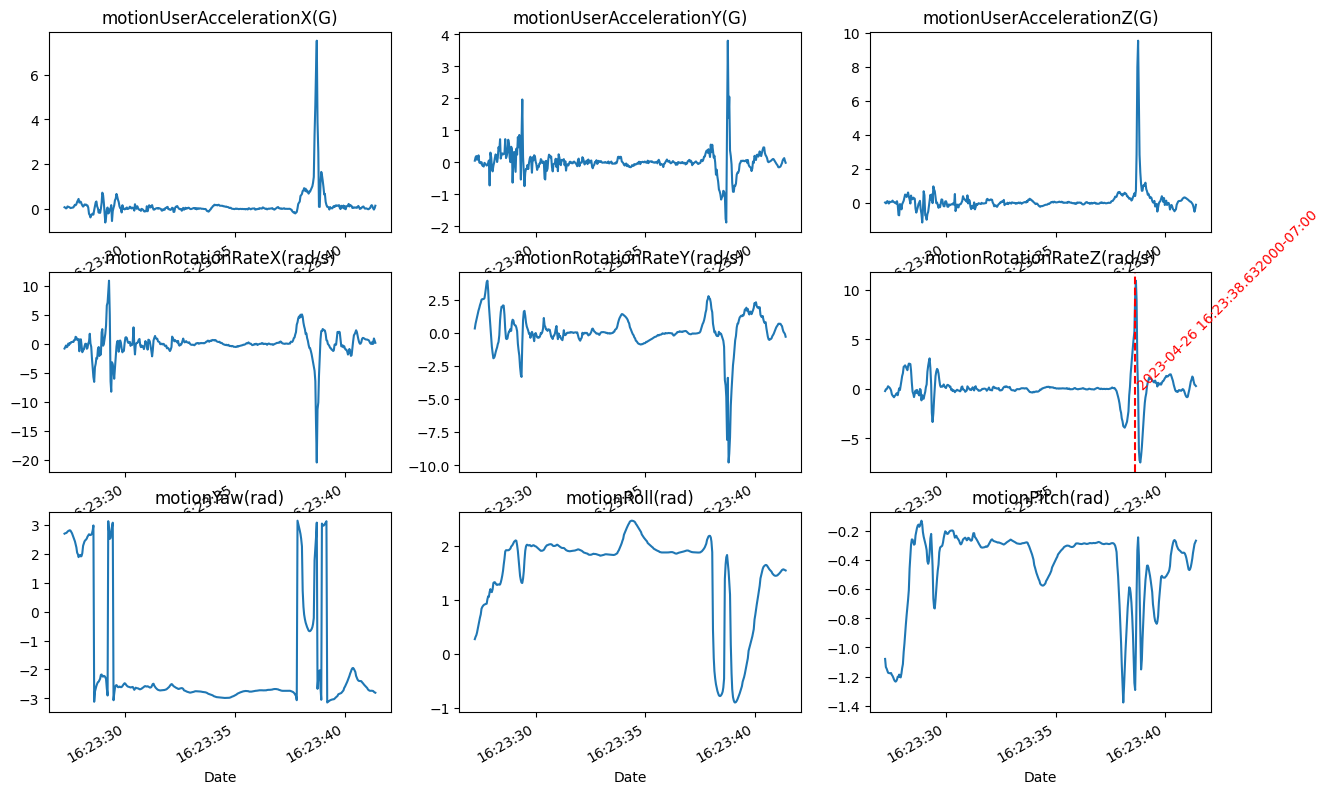

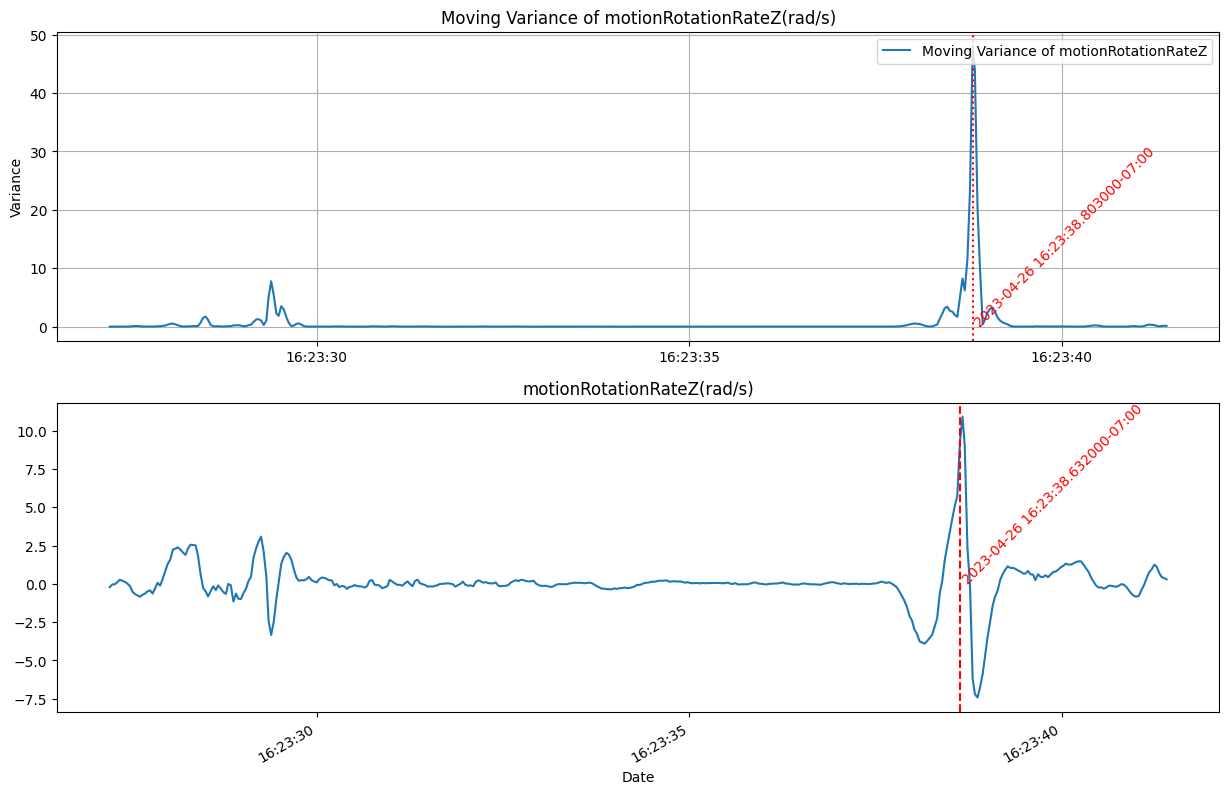

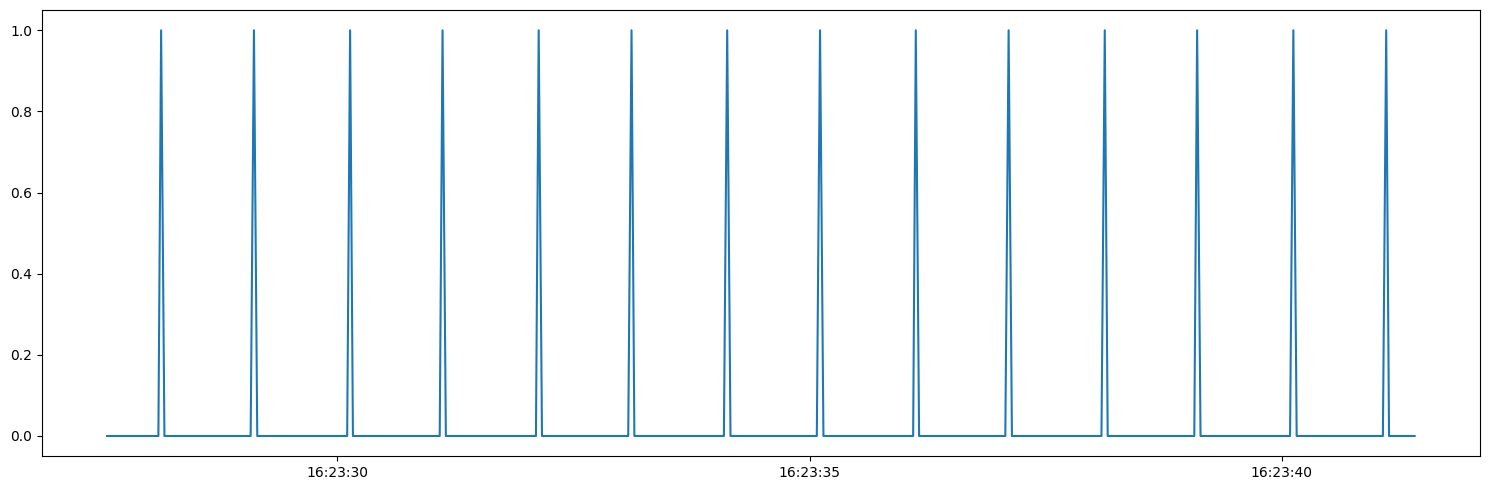

2023-04-26 16:23:28.133000-07:00
Total Distance: 100.25
Shift offset: 13 | (8104, 8524)
420 | 2023-04-26 16:23:28.133000-07:00 - 2023-04-26 16:23:42.324000-07:00


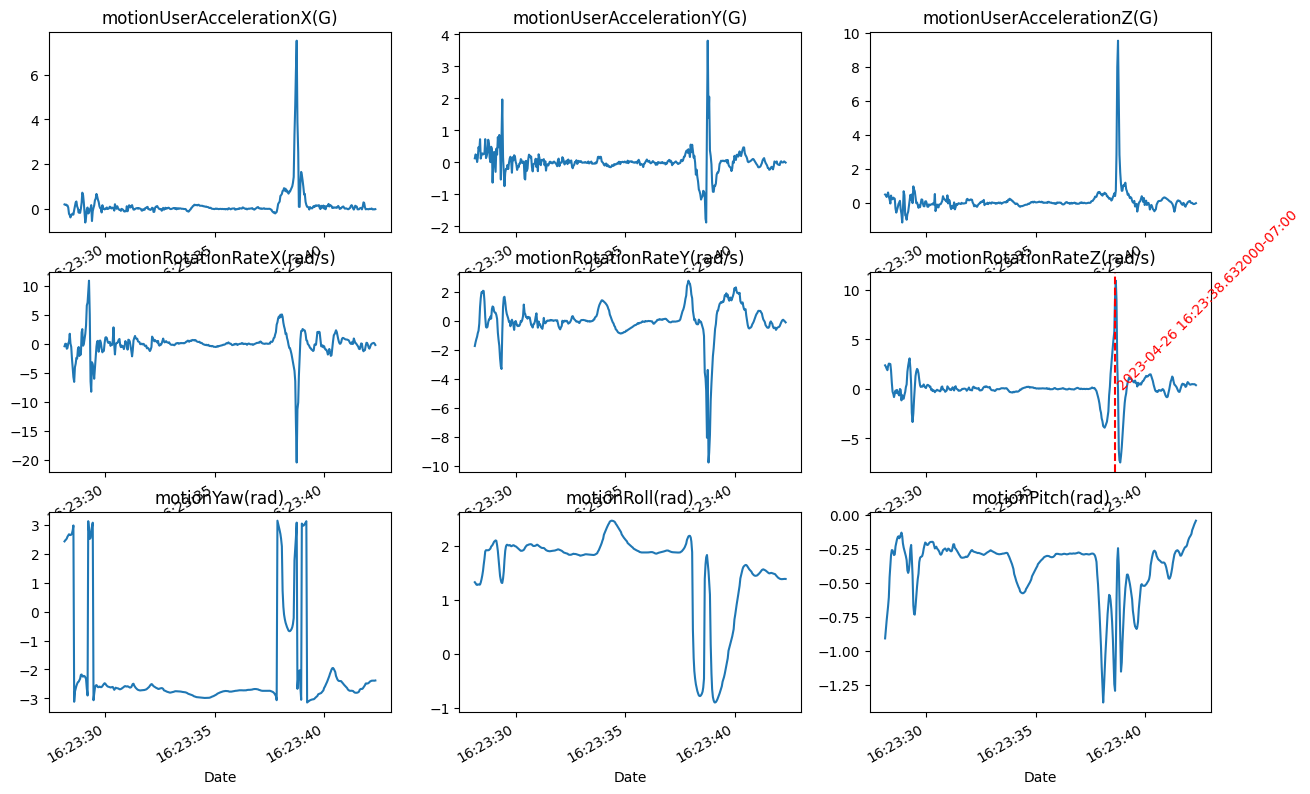

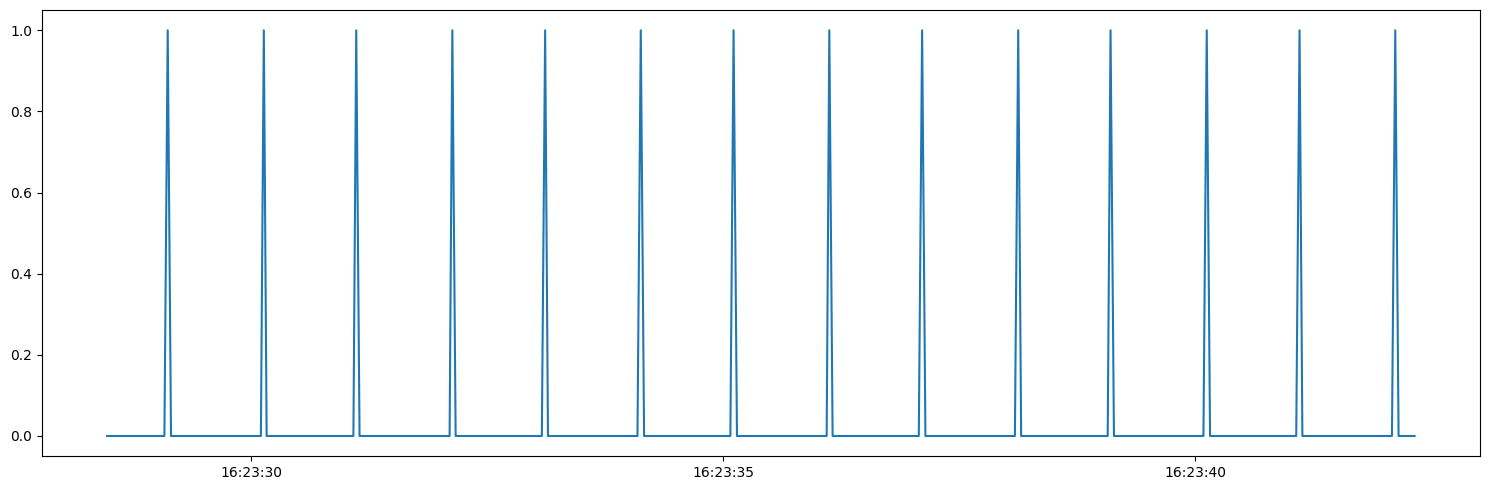

2023-04-26 16:23:28.068000-07:00
Total Distance: 100.25
Shift offset: 11 | (8102, 8522)
420 | 2023-04-26 16:23:28.068000-07:00 - 2023-04-26 16:23:42.254000-07:00


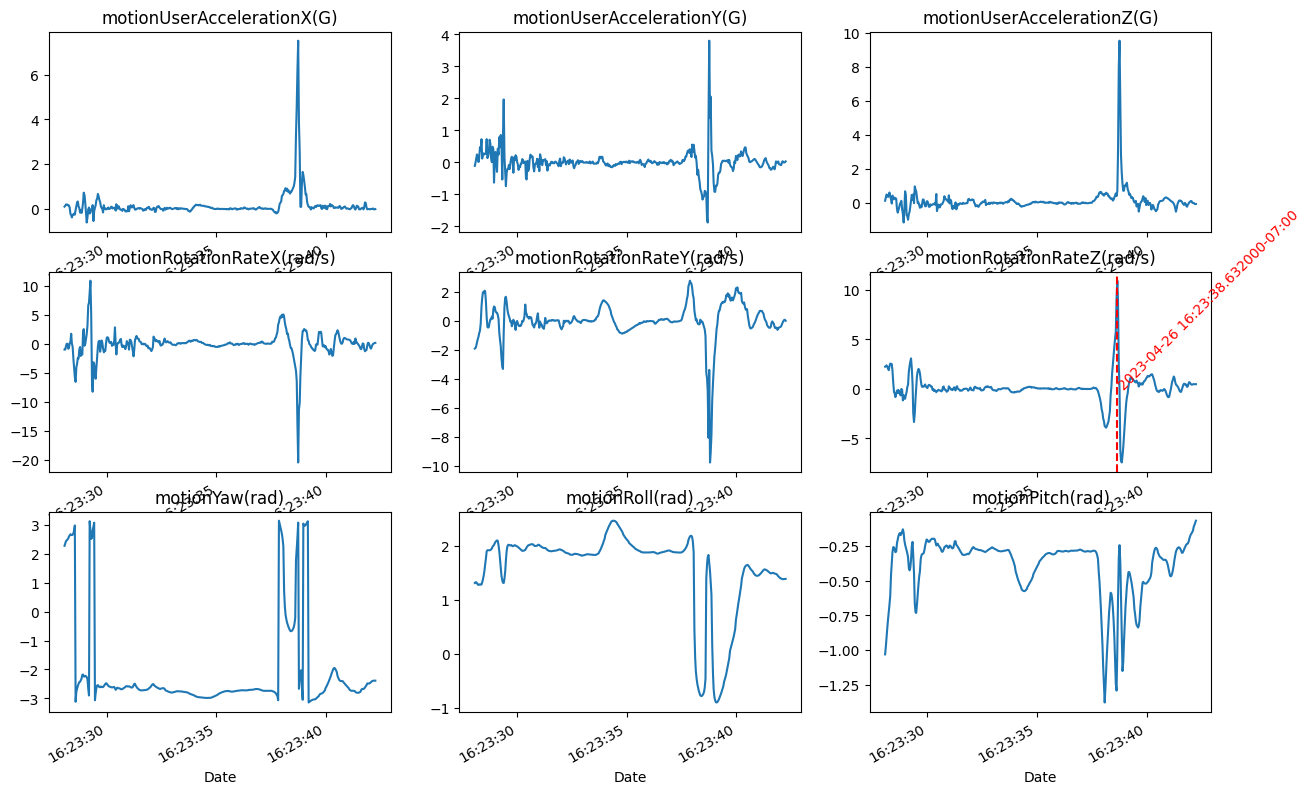

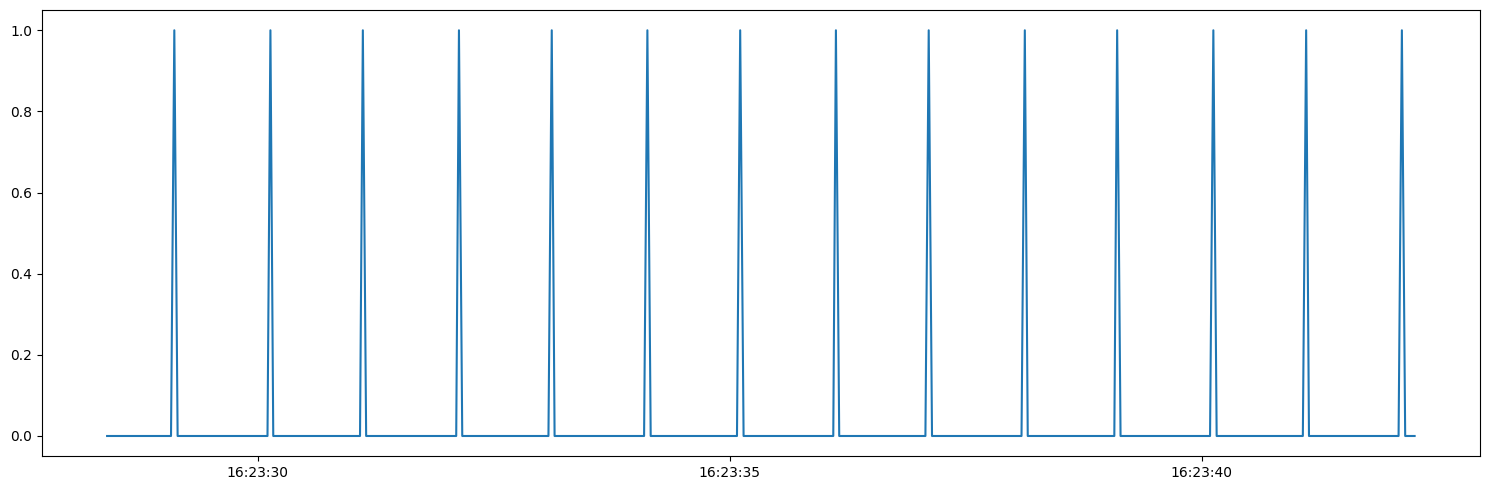

2023-04-26 16:28:40.403000-07:00
Total Distance: 139.86
Shift offset: -8 | (17033, 17453)
420 | 2023-04-26 16:28:40.403000-07:00 - 2023-04-26 16:28:54.590000-07:00


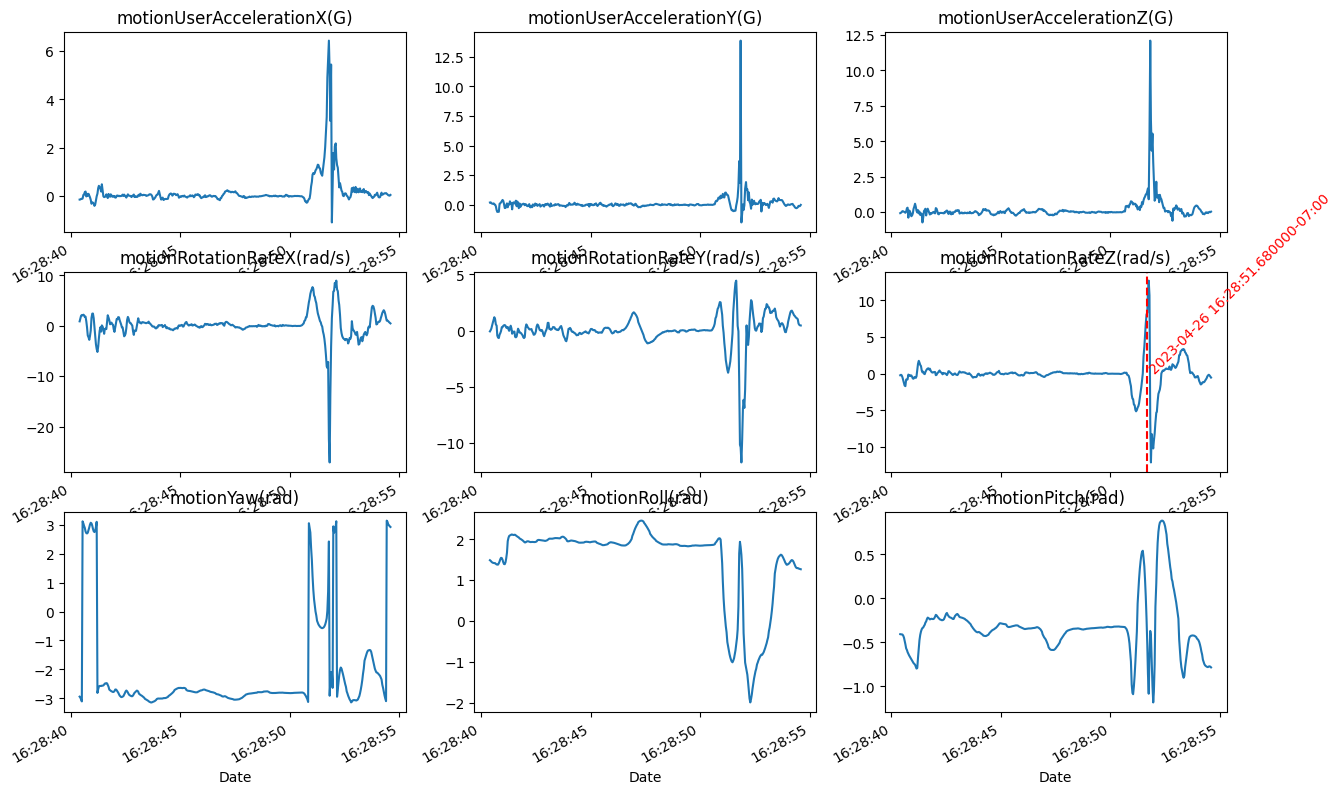

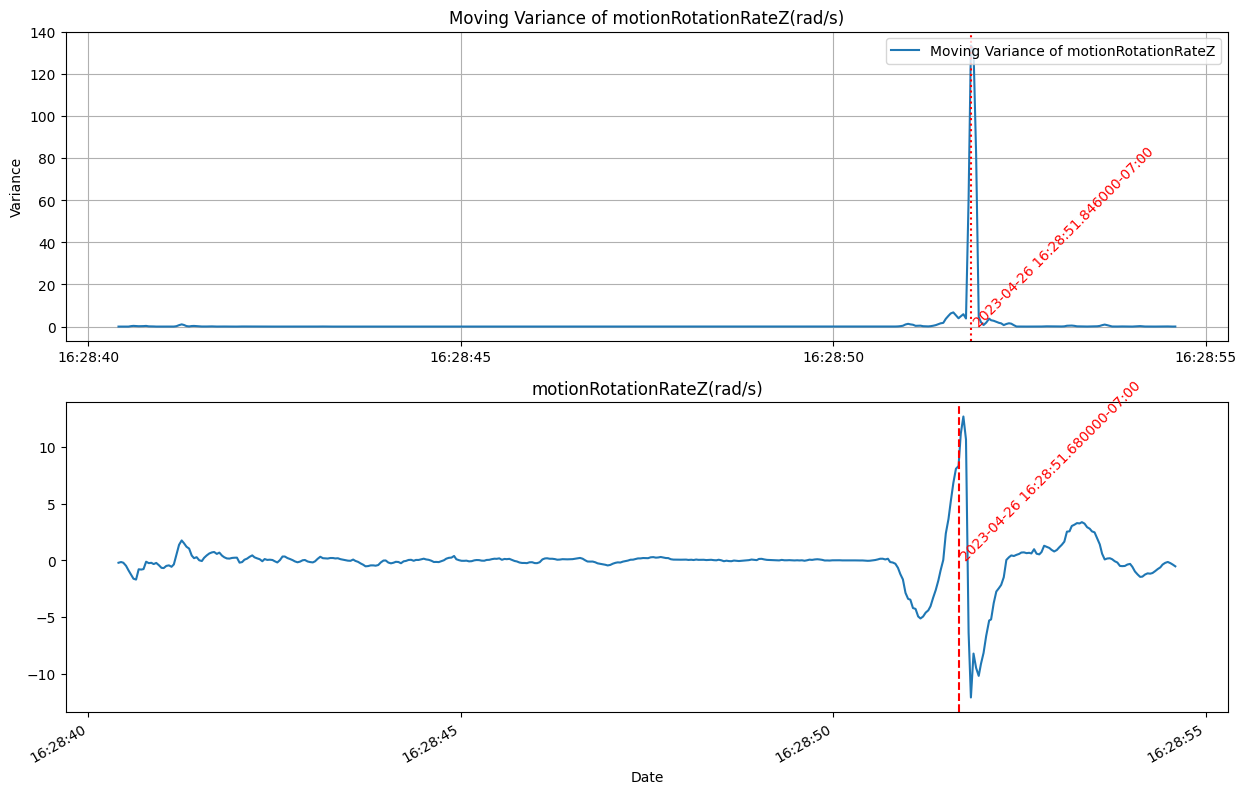

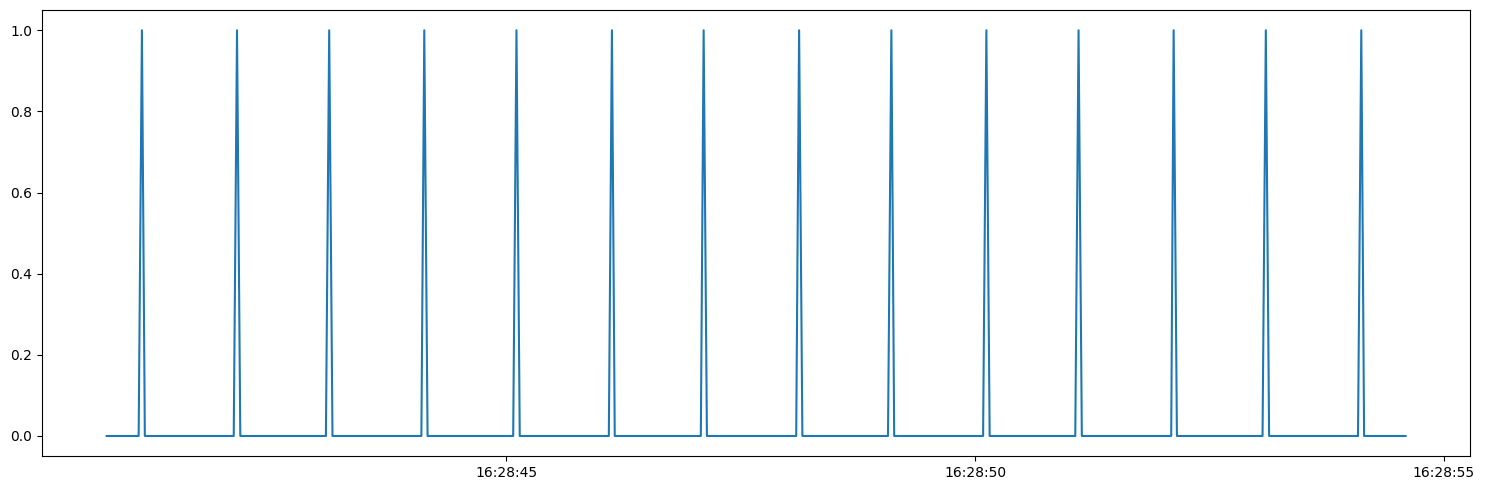

2023-04-26 16:32:01.333000-07:00
Total Distance: 165.49
Shift offset: 0 | (22273, 22693)
420 | 2023-04-26 16:32:01.333000-07:00 - 2023-04-26 16:32:15.525000-07:00


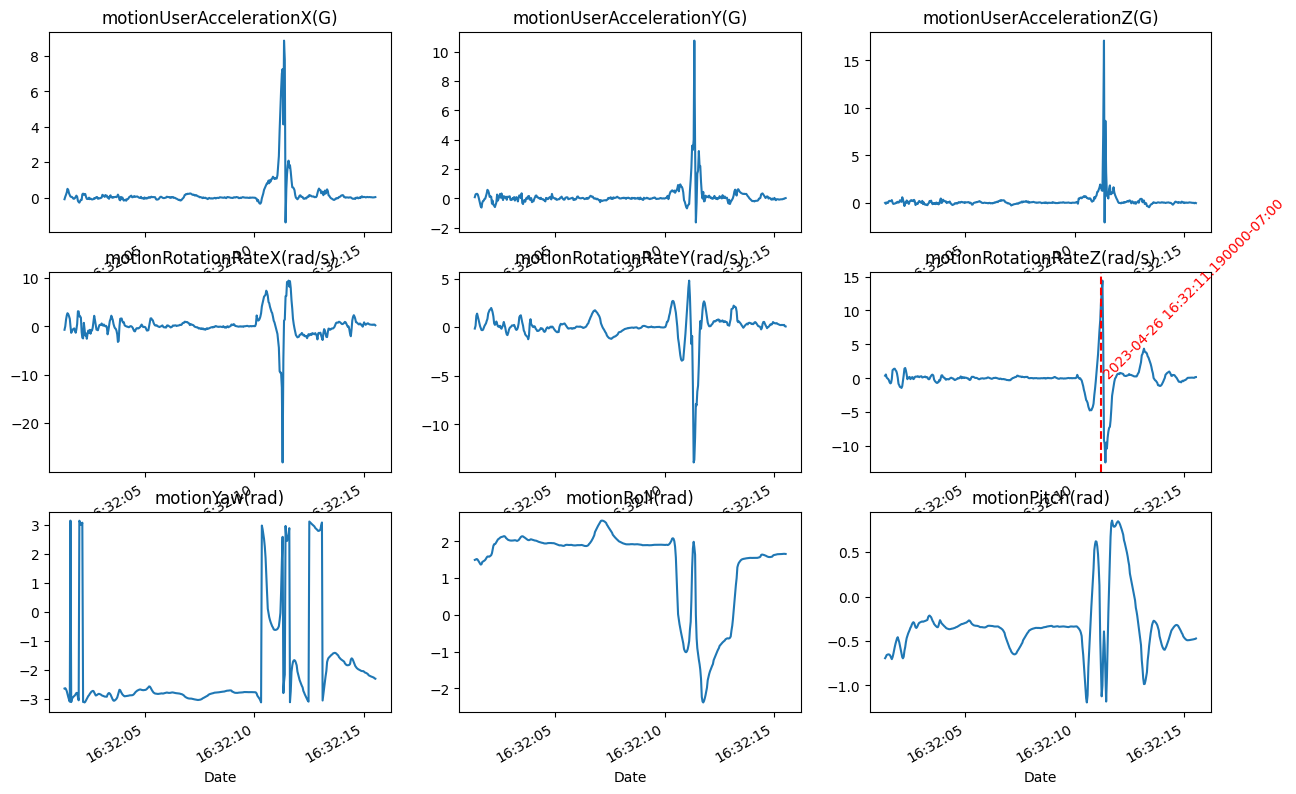

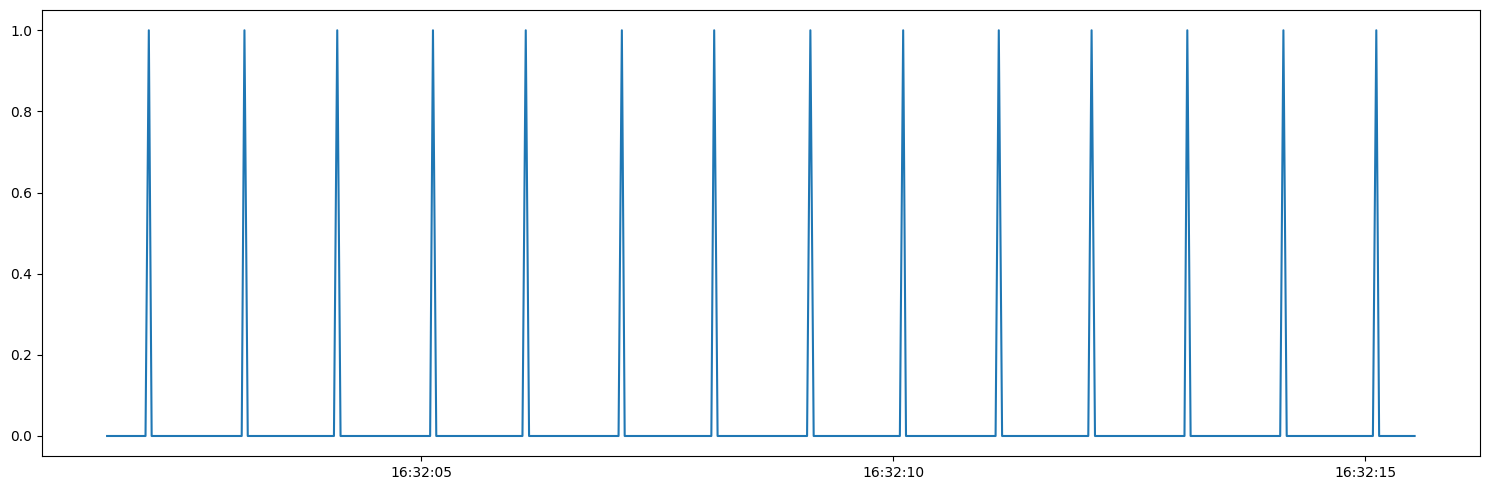

2023-06-01 14:04:15.351000-07:00
Total Distance: 169.06
Shift offset: -7 | (144623, 145043)
420 | 2023-06-01 14:04:15.351000-07:00 - 2023-06-01 14:04:29.537000-07:00


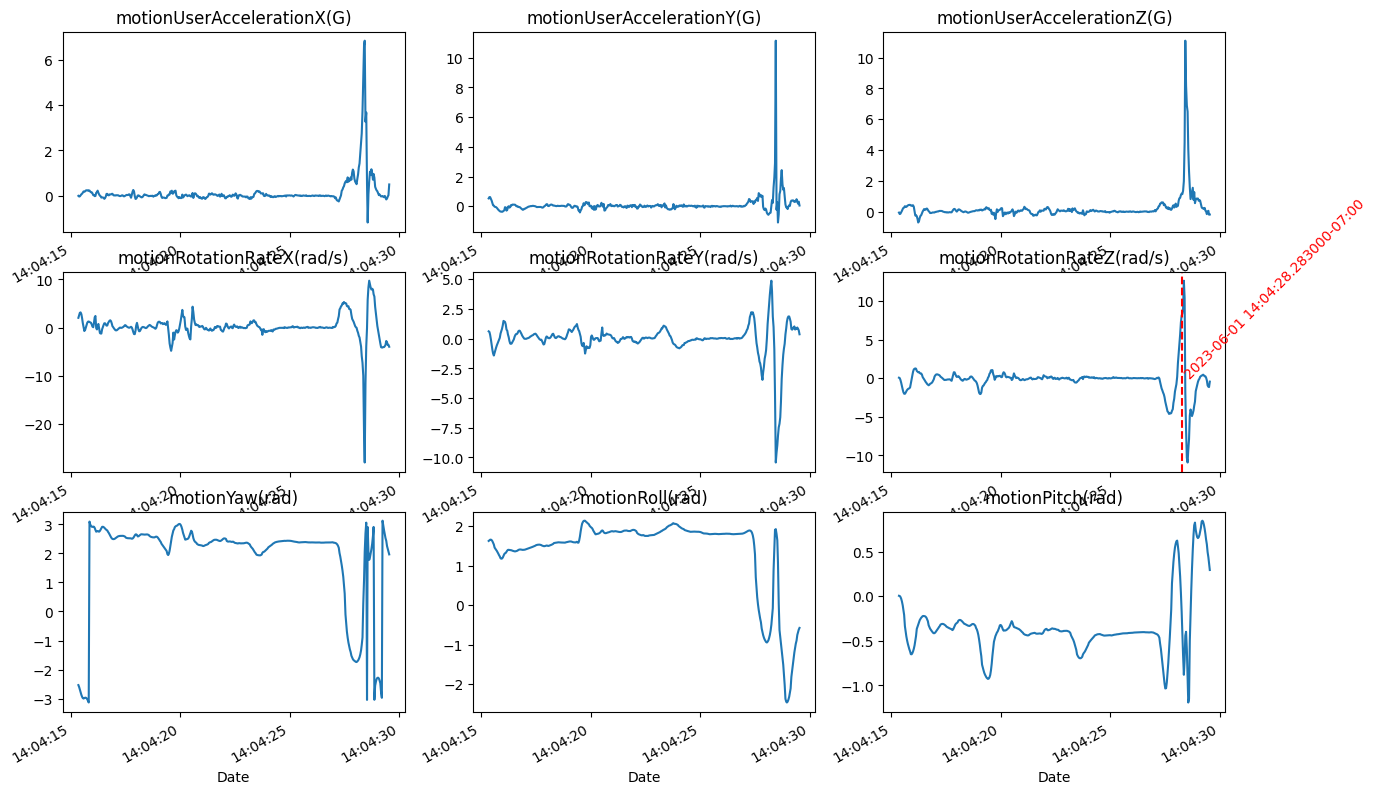

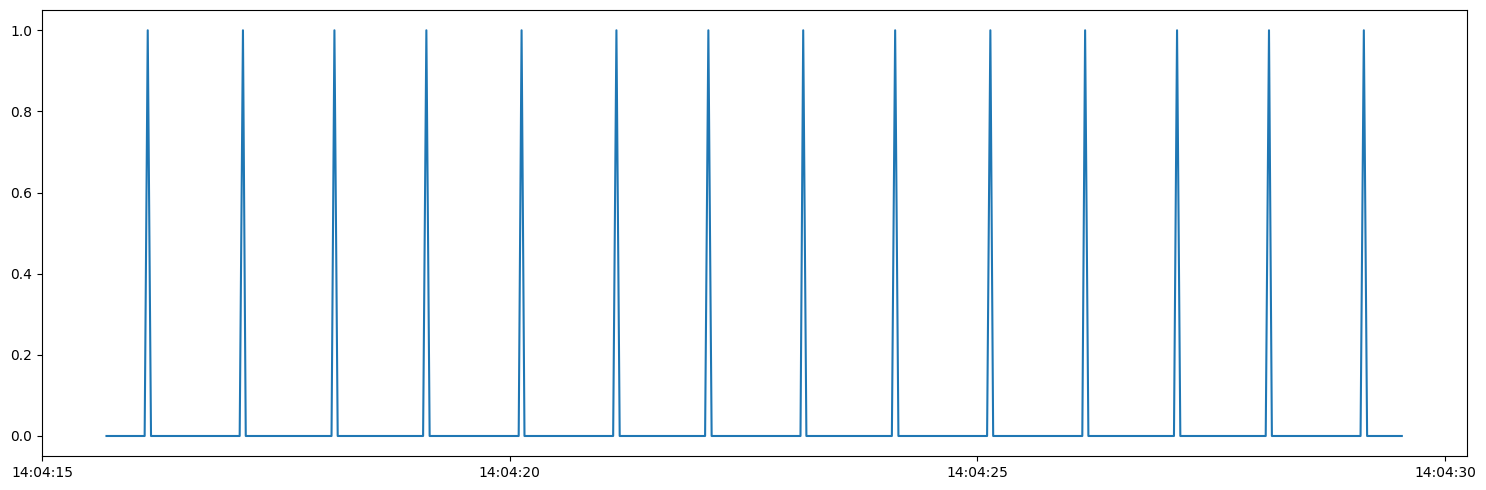

In [50]:
visualize_sample(mapped[3], plot_z_variance=True)
visualize_sample(mapped[4])
visualize_sample(mapped[5])
visualize_sample(mapped[50], plot_z_variance=True)
visualize_sample(mapped[80])
visualize_sample(mapped[-1])

2023-05-11 13:33:43.259000-07:00
5000 | 2023-05-11 13:33:43.259000-07:00 - 2023-05-11 13:36:32.504000-07:00


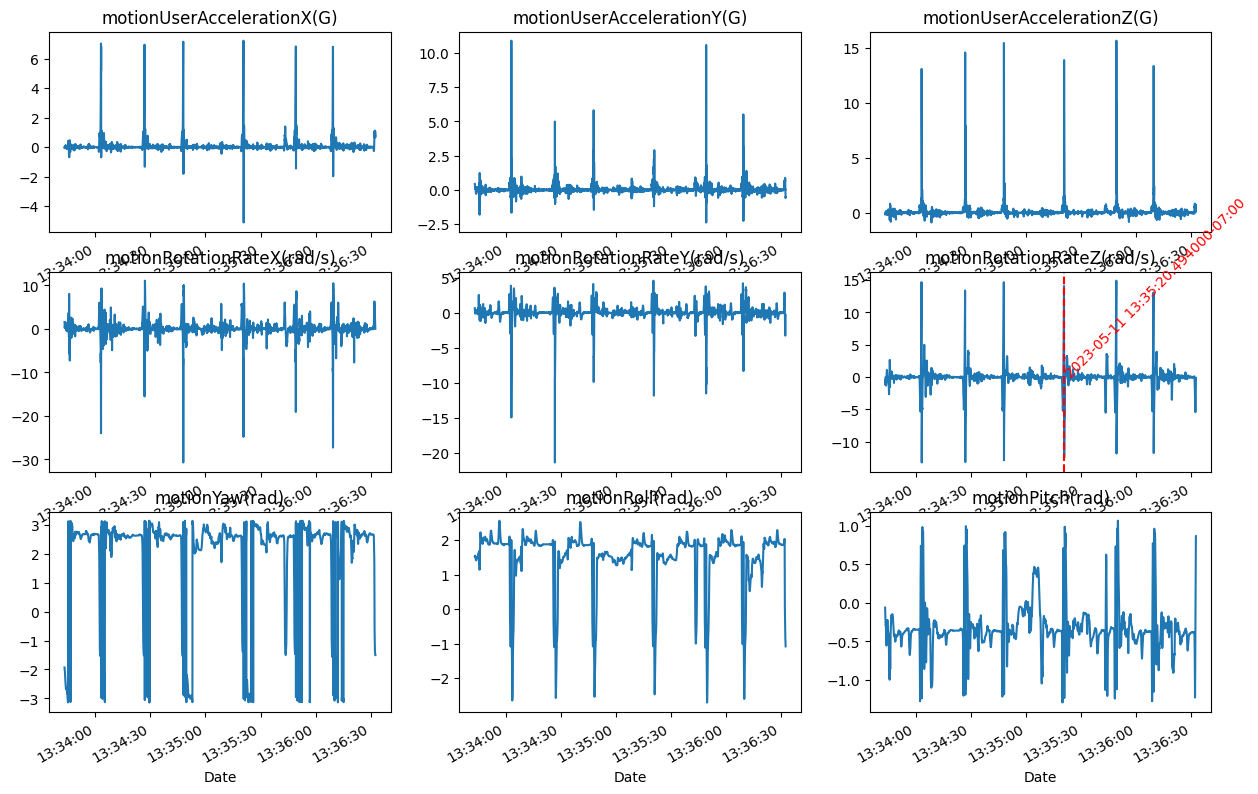

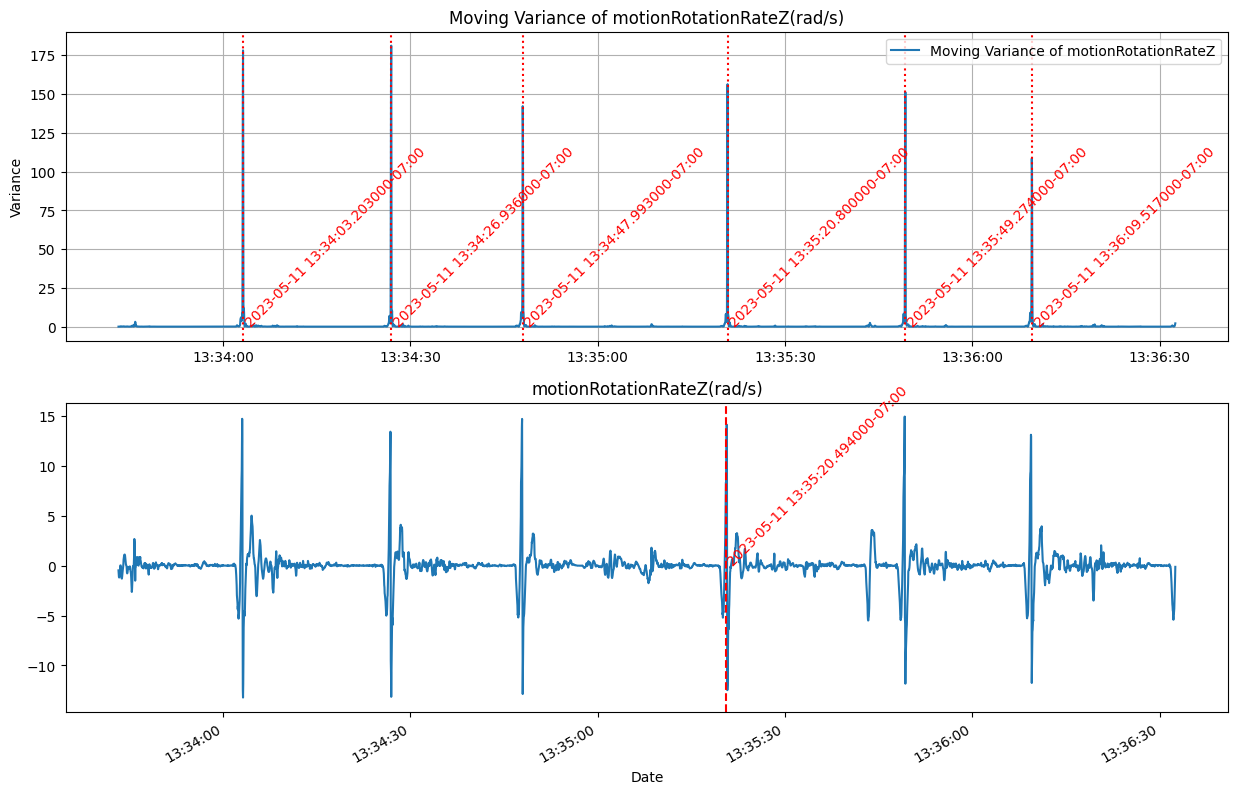

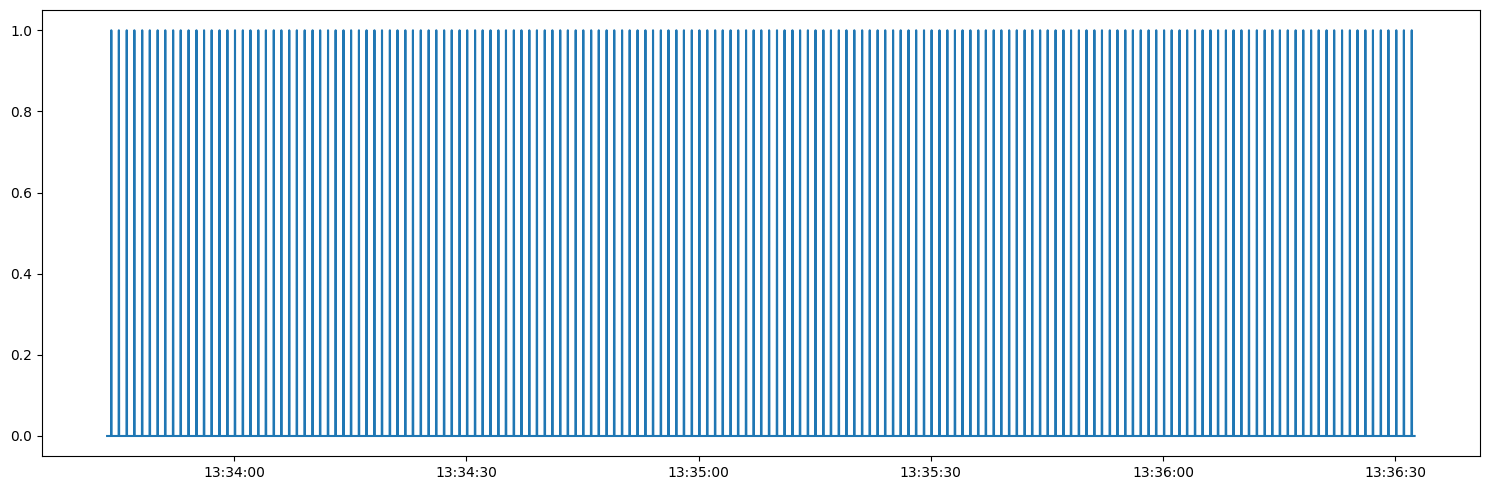

In [51]:
visualize_sample((None, applewatchdata[50000:55000]), True)

In [52]:
print(launchdata['Club Type'].unique())
print(launchdata['Club Description'].unique())
print(launchdata['Shot Classification'].unique())

['8 Iron' 'Sand Wedge' '7 Iron' '5 Iron' 'Driver']
[nan]
['Straight' 'Push' 'Hook' 'Slice' 'Push Draw' 'Push Fade' 'Draw' 'Pull'
 'Push Hook' 'Pull Hook' 'Pull Draw' 'Push Slice' 'Fade']


In [53]:
def map_club_data(club_type):
    return [x for x in CLUB_TYPE_MAPPING[club_type]]

In [54]:
# TODO: Normalize Data

def generate_x_ts_sample(applewatchdata_segment):
    df = applewatchdata_segment

    # TODO: Could potentially down sample these to reduce size but 30hz could probably work too.

    # Select only the columns we want to use in our training
    selected_columns = [
        'motionUserAccelerationX(G)',
        'motionUserAccelerationY(G)',
        'motionUserAccelerationZ(G)',
        'motionRotationRateX(rad/s)',
        'motionRotationRateY(rad/s)',
        'motionRotationRateZ(rad/s)',
        'motionYaw(rad)',
        'motionRoll(rad)',
        'motionPitch(rad)'
    ]
    # Convert to a 2D numpy array of shape (Tx, 9), where Tx is the number of time steps
    ts_array = df[selected_columns].values

    return ts_array

def generate_x_aux_sample(launchdata_sample):
    club_type = launchdata_sample['Club Type']
    # TODO: Maybe club_type and stiffness should be one-hot encoding
    club_data = map_club_data(club_type)
    return np.array(club_data)

def generate_y_sample(launchdata_sample):
    df = launchdata_sample

    # Could potentially switch to classification problem (Straight, Push, Hook, Draw, ...)
    selected_columns = [
        'Carry Distance',
        'Total Distance',
        'Attack Angle',
    ]
    df[selected_columns] = df[selected_columns].astype(float)
    y_array = df[selected_columns].values

    return y_array


In [55]:
def generate_training_data(mapped_data):
    X_ts = []
    X_aux= []
    Y = []
    for launch, awdata in mapped_data:
        x_ts = generate_x_ts_sample(awdata)
        x_aux = generate_x_aux_sample(launch)
        y = generate_y_sample(launch)

        X_ts.append(x_ts)
        X_aux.append(x_aux)
        Y.append(y)

    X_ts = np.array(X_ts)
    X_aux = np.array(X_aux)
    Y = np.array(Y)

    return X_ts, X_aux, Y

In [56]:
X_ts, X_aux, Y = generate_training_data(mapped)

# Save to disk so we can load it during model training.
# Note that these are pre-split data
os.makedirs('./saved/processed_data/', exist_ok=True)
np.save('./saved/processed_data/X_ts.npy', X_ts)
np.save('./saved/processed_data/X_aux.npy', X_aux)
np.save('./saved/processed_data/Y.npy', Y)

print(X_ts.shape)
print(X_aux.shape)
print(Y.shape)

(1312, 420, 9)
(1312, 9)
(1312, 3)
